In [60]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import style
style.use('fivethirtyeight')
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
import scipy.stats as sps

In [66]:

dataset = pd.read_csv('./spam_email.csv', sep='\s+', engine='python', header=0)
dataset.rename(columns={'#a':'a'}, inplace=True)
dataset.head()

,make,address,all,3d,our,over,remove,internet,order,mail,...,semicol,paren,bracket,bang,dollar,pound,cap_avg,cap_long,cap_total,Class
0,0.00,0.00,0.29,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.178,0.0,0.044,0.000,0.00,1.666,10,180,ham
1,0.46,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.125,0.0,0.000,0.000,0.00,1.510,10,74,ham
2,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.000,0.000,0.00,1.718,11,55,ham
3,0.33,0.44,0.37,0.0,0.14,0.11,0.00,0.07,0.97,1.16,...,0.006,0.159,0.0,0.069,0.221,0.11,3.426,72,819,spam
4,0.00,2.08,0.00,0.0,3.12,0.00,1.04,0.00,0.00,0.00,...,0.000,0.000,0.0,0.263,0.000,0.00,1.428,4,20,spam


In [67]:
dataset.columns

Index(['make', 'address', 'all', '3d', 'our', 'over', 'remove', 'internet',
       'order', 'mail', 'receive', 'will', 'people', 'report', 'addresses',
       'free', 'business', 'email', 'you', 'credit', 'your', 'font', '000',
       'money', 'hp', 'hpl', 'george', '650', 'lab', 'labs', 'telnet', '857',
       'data', '415', '85', 'technology', '1999', 'parts', 'pm', 'direct',
       'cs', 'meeting', 'original', 'project', 're', 'edu', 'table',
       'conference', 'semicol', 'paren', 'bracket', 'bang', 'dollar', 'pound',
       'cap_avg', 'cap_long', 'cap_total', 'Class'],
      dtype='object')

In [68]:
for label in dataset.columns:
    dataset[label] = LabelEncoder().fit(dataset[label]).transform(dataset[label])

    
    
Tree_model = DecisionTreeClassifier(criterion="entropy",max_depth=1)


X = dataset.drop('Class',axis=1)
Y = dataset['Class'].where(dataset['Class']==1,-1)



predictions = np.mean(cross_validate(Tree_model,X,Y,cv=100)['test_score'])


print('The accuracy is: ',predictions*100,'%')

The accuracy is:  76.83163737280296 %


With a number of  50 base models we receive an accuracy of  93.54488154748968 %


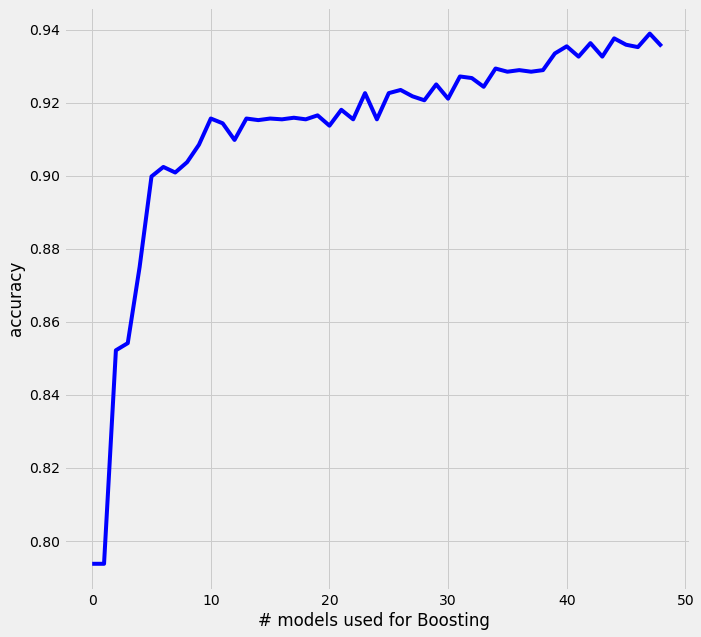

In [70]:
class Boosting:
    
    def __init__(self,dataset,T,test_dataset):
        self.dataset = dataset
        self.T = T
        self.test_dataset = test_dataset
        self.alphas = None
        self.models = None
        self.accuracy = []
        self.predictions = None
    
    def fit(self):
        # Set the descriptive features and the target feature
        X = self.dataset.drop(['Class'],axis=1)
        Y = self.dataset['Class'].where(self.dataset['Class']==1,-1)

     
        Evaluation = pd.DataFrame(Y.copy())
        Evaluation['weights'] = 1/len(self.dataset) # Set the initial weights w = 1/N
        

       
        
        alphas = [] 
        models = []
        
        for t in range(self.T):

            # Train the Decision Stump(s)
            Tree_model = DecisionTreeClassifier(criterion="entropy",max_depth=1) 
            
            # which is exactly what we want to have.
            model = Tree_model.fit(X,Y,sample_weight=np.array(Evaluation['weights'])) 
            
            # Append the single weak classifiers to a list which is later on used to make the 
            # weighted decision
            models.append(model)
            predictions = model.predict(X)
            score = model.score(X,Y)

            # Add values to the Evaluation DataFrame
            Evaluation['predictions'] = predictions
            Evaluation['evaluation'] = np.where(Evaluation['predictions'] == Evaluation['Class'],1,0)
            Evaluation['misclassified'] = np.where(Evaluation['predictions'] != Evaluation['Class'],1,0)

            # Calculate the misclassification rate and accuracy
            accuracy = sum(Evaluation['evaluation'])/len(Evaluation['evaluation'])
            misclassification = sum(Evaluation['misclassified'])/len(Evaluation['misclassified'])


            # Caclulate the error
            err = np.sum(Evaluation['weights']*Evaluation['misclassified'])/np.sum(Evaluation['weights'])
 
   
            # Calculate the alpha values
            alpha = np.log((1-err)/err)
            alphas.append(alpha)


            Evaluation['weights'] *= np.exp(alpha*Evaluation['misclassified'])

        self.alphas = alphas
        self.models = models
            
    def predict(self):
        X_test = self.test_dataset.drop(['Class'],axis=1).reindex(range(len(self.test_dataset)))
        Y_test = self.test_dataset['Class'].reindex(range(len(self.test_dataset))).where(self.dataset['Class']==1,-1)
    
        accuracy = []
        predictions = []
        
        for alpha,model in zip(self.alphas,self.models):
            prediction = alpha*model.predict(X_test)
            predictions.append(prediction)
            self.accuracy.append(np.sum(np.sign(np.sum(np.array(predictions),axis=0))==Y_test.values)/len(predictions[0]))
            
        self.predictions = np.sign(np.sum(np.array(predictions),axis=0))

   
        

        




number_of_base_learners = 50

fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)


for i in range(number_of_base_learners):
    model = Boosting(dataset,i,dataset)
    model.fit()
    model.predict()

ax0.plot(range(len(model.accuracy)),model.accuracy,'-b')
ax0.set_xlabel('# models used for Boosting ')
ax0.set_ylabel('accuracy')
print('With a number of ',number_of_base_learners,'base models we receive an accuracy of ',model.accuracy[-1]*100,'%')    
                 
plt.show()     